# <center>Time series analysis in Python</center>


## План

1. Machine Learning для временных рядов
  * Feature extraction, engineering, предобработка данных, какие признаки и как можно извлечь
  * Линейные модели, обучаем, смотрим качество на кросс-валидации, оцениваем важность признаков
  * Регуляризация, отбор признаков, сокращение признакового пространства, ridge, lasso
  * Бустиг для временных рядов - ограничения и преимущества
2. To Infinity and Beyond 
  * Facebook Prophet - автоматические прогнозы
  * Amazon GluonTS - нейросети для временных рядов
  * tsfresh - автоматические признаки

In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots
sns.set()

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# import warnings                                  # `do not disturbe` mode
# warnings.filterwarnings('ignore')

%matplotlib inline

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

# def mean_absolute_percentage_error(y_true, y_pred): 
#     return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

%matplotlib inline
plt.rcParams["figure.figsize"] = [14, 10]

%config Completer.use_jedi = False

print("Imports Done!")

Imports Done!


In [2]:
PATH = '~/PycharmProjects/Datasets/'

In [3]:
ads = pd.read_csv(PATH + 'ads.csv', index_col=['Time'], parse_dates=['Time'])
currency = pd.read_csv(PATH + 'currency.csv', index_col=['Time'], parse_dates=['Time'])

In [4]:
ads.head()

,Ads
Time,
2017-09-13 00:00:00,80115
2017-09-13 01:00:00,79885
2017-09-13 02:00:00,89325
2017-09-13 03:00:00,101930
2017-09-13 04:00:00,121630


In [5]:
currency.head()

,GEMS_GEMS_SPENT
Time,
2017-05-01,1199436
2017-05-02,1045515
2017-05-03,586111
2017-05-04,856601
2017-05-05,793775


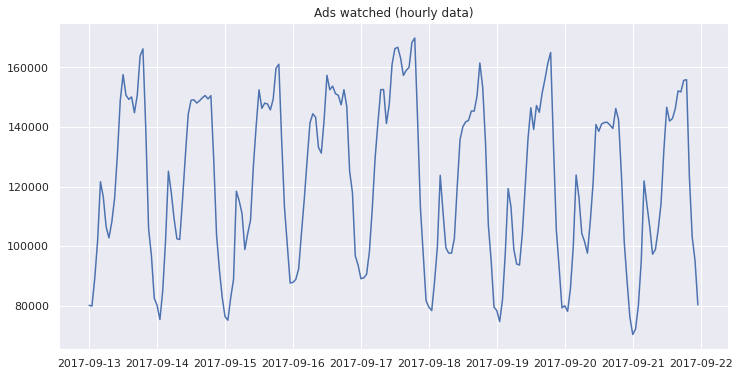

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

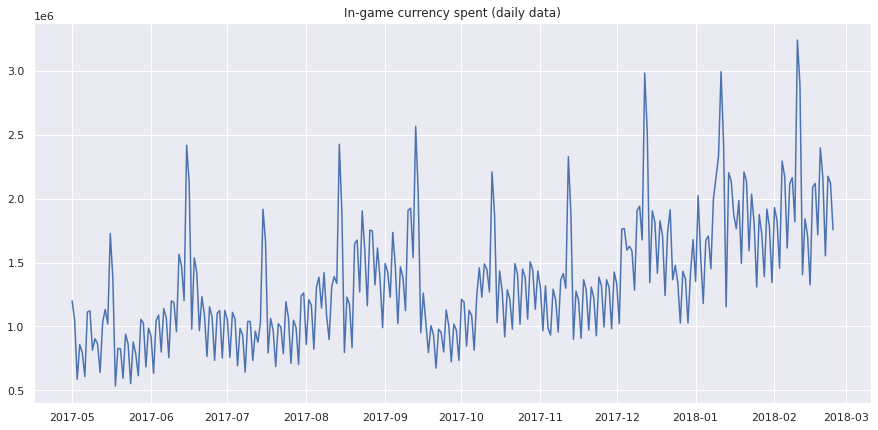

In [7]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('In-game currency spent (daily data)')
plt.grid(True)
plt.show()

# 1) Machine Learning для временных рядов

### Временные ряды без правил или прогнозируем, чем можем

Снова небольшое лирическое отступление. Часто на работе приходится строить модели, руководствуясь одним основополагающим принципом – [быстро, качественно, недорого](http://lurkmore.to/%D0%91%D1%8B%D1%81%D1%82%D1%80%D0%BE,_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B5%D0%BD%D0%BD%D0%BE,_%D0%BD%D0%B5%D0%B4%D0%BE%D1%80%D0%BE%D0%B3%D0%BE). Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных, либо сложно настраиваются, либо требуют частого переобучения на новых данных, поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.


Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

### Извлечение признаков (Feature exctraction)

Итак, для модели нужны признаки, а у нас есть только одномерный временной ряд, что можно придумать?

* Конечно же, лаги временного ряда
* Статистики по окнам:
    - Минимальное/максимальное значение ряда в окне
    - Среднеё/медианное значение по окну
    - Дисперсия по окну
    - и т.д.
* Признаки из самой даты и времени:
    - Минута часа, час дня, день недели, месяц года и т.д.
    - Является ли день праздником/выходным/специфическим днём
* Кодирование средним
* Прогнозы других моделей (но тут в скорости можно потерять)

Пройдемся по некоторым из способов и посмотрим, что мы можем вытащить из нашего временного ряда с рекламой

### Лаги временного ряда

Сдвигая ряд на $n$ шагов мы получаем столбец-признак, в котором текущему значению ряда в момент $t$ будет соответствовать его значение в момент времени $t-n$. Таким образом, если сделать отступ в 1 шаг, то модель, обученная на таком признаке, будет способна давать предсказание на 1 шаг вперед, зная текущее состояние ряда. Увеличивая сдвиг, например, до 6 лага позволит модели делать предсказания на 6 шагов вперёд, однако опираться она будет на данные, которые видела 6 временных периодов назад и если за это время что-то кардинально поменялось, модель сразу не уловит изменений и выдаст прогноз с большой ошибкой. Поэтому при выборе начального лага приходиться балансировать между желанием получить предсказания на бОльшее число периодов вперёд и приемлимым качеством предсказания

In [8]:
# Creating a copy of the initial datagrame to make various transformations 
data = pd.DataFrame(ads.Ads.copy())
data.columns = ["y"]

In [9]:
# Adding the lag of the target variable from 6 steps back up to 24
for i in range(6, 25):
    data["lag_{}".format(i)] = data.y.shift(i)

In [10]:
# take a look at the new dataframe 
data.tail(7)

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
Time,,,,,,,,,,,,,,,,,,,,
2017-09-21 17:00:00,151790,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0,139515.0
2017-09-21 18:00:00,155665,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,146215.0
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0


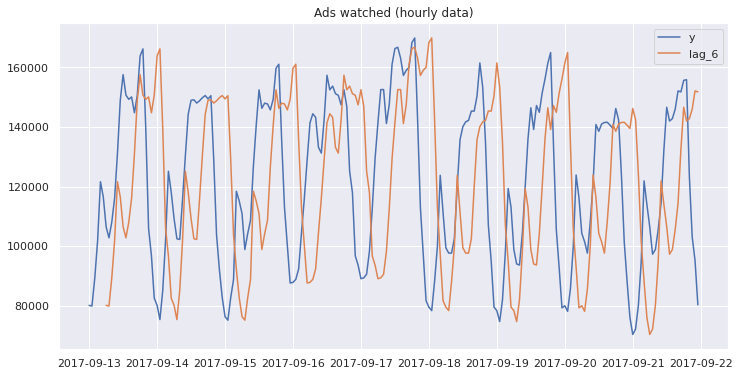

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data.y, label='y')
plt.plot(data.index, data.lag_6, label='lag_6')
plt.title('Ads watched (hourly data)')
plt.legend()
plt.grid(True)
plt.show()

Шикарно, у нас есть датасет, почему бы не построить модель!

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit

# for time-series cross-validation set 5 folds 
tscv = TimeSeriesSplit(n_splits=5)

In [13]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index-1]
    y_train = y.iloc[:test_index-1]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [14]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

# reserve 30% of data for testing
X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

In [15]:
# machine learning in two lines
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [16]:
def plotModelResults(model, X_train=X_train, X_test=X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error * 100))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

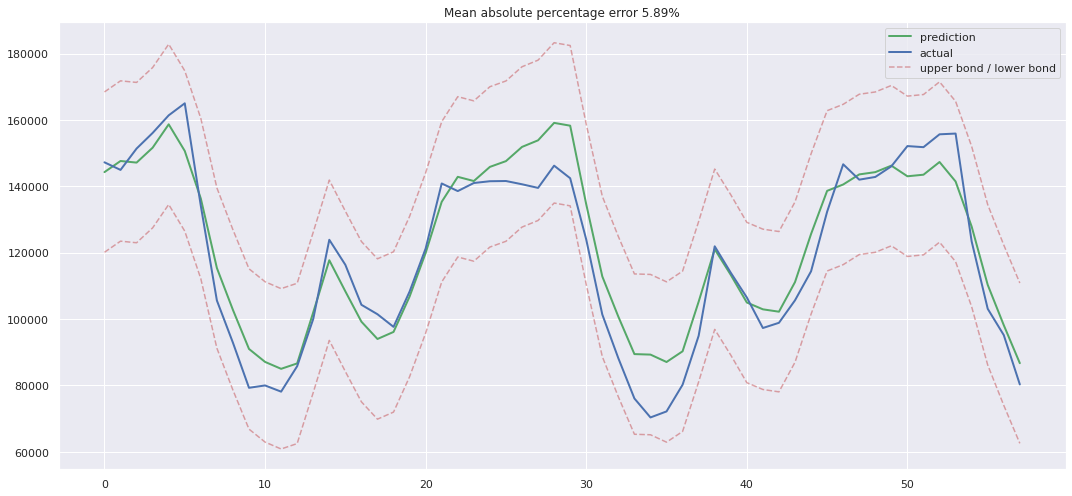

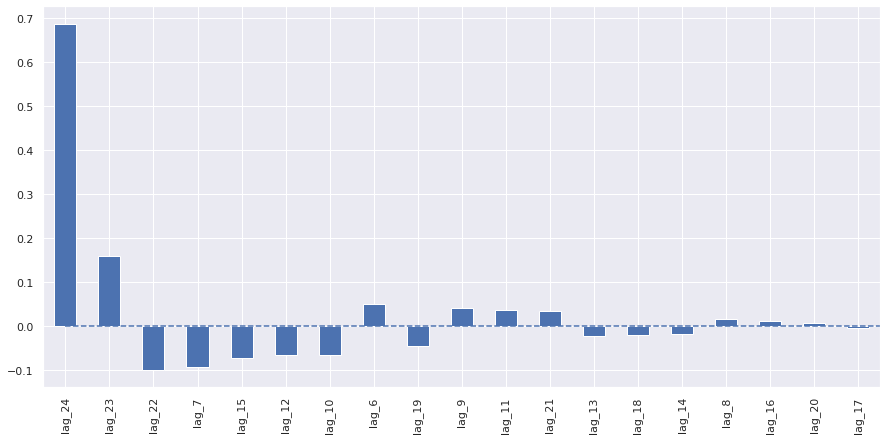

In [17]:
plotModelResults(lr, plot_intervals=True)
plotCoefficients(lr)

Что ж, всего лишь простыми лагами удалось построить модель, которая не сильно уступает по качеству SARIMA модели. Пока что в модели есть достаточно много мусорных факторов, но отбором займемся чуть позже, а пока продолжим придумывать признаки!

Добавим в датасет час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [18]:
data.index = pd.to_datetime(data.index)
data["hour"] = data.index.hour
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6])*1
data.tail()

,y,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,hour,weekday,is_weekend
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-21 19:00:00,155890,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,113950.0,...,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,142425.0,19,3,0
2017-09-21 20:00:00,123395,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,106495.0,...,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,123945.0,20,3,0
2017-09-21 21:00:00,103080,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,97290.0,...,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,101360.0,21,3,0
2017-09-21 22:00:00,95155,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,98860.0,...,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,88170.0,22,3,0
2017-09-21 23:00:00,80285,151790.0,152120.0,146020.0,142815.0,141995.0,146630.0,132335.0,114380.0,105635.0,...,113950.0,121910.0,94945.0,80195.0,72150.0,70335.0,76050.0,23,3,0


Можно визуализировать получившиеся признаки

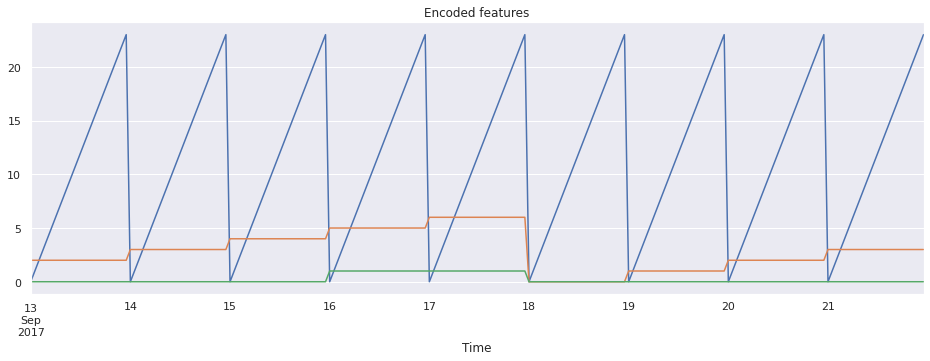

In [19]:
plt.figure(figsize=(16, 5))
plt.title("Encoded features")
data.hour.plot()
data.weekday.plot()
data.is_weekend.plot()
plt.grid(True);

Так как теперь у нас данные в разном масштабе - десятки тысяч в лагах и единицы в категориях, имеет смысл привести всё к одному масштабу, чтобы можно было по-прежнему исследовать коэффициенты модели. Для этого воспользуемся `StandardScaler`

Также, раз мы работаем с линейной моделью, имеет смысл преобразовать категориальные переменные в дамми

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

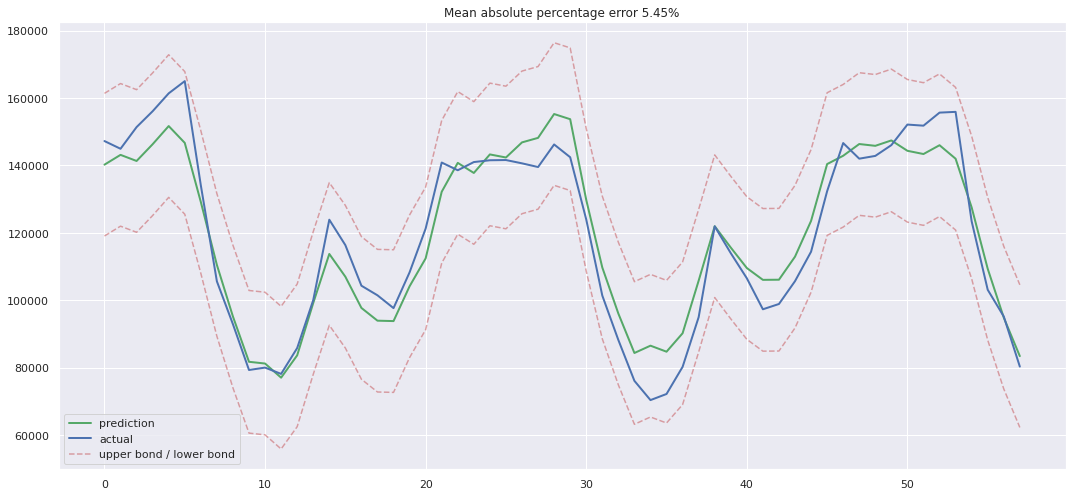

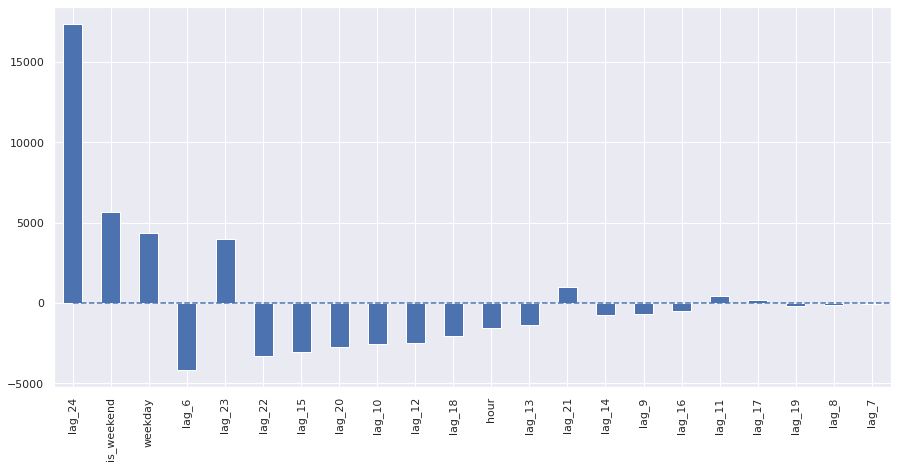

In [21]:
y = data.dropna().y
X = data.dropna().drop(['y'], axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Ошибка на тесте еще немного уменьшилась, и по коэффициентам видно, что день недели и выходной - довольно неплохие признаки

### Кодирование средним (target encoding)

Иногда в качестве признака добавлять среднее значение целевой переменной. В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом просмотров рекламы/траты инровой валюты, пришедшиеся на этот день недели или этот час. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тренировочного датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем.

In [22]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Посмотрим на средние по часам

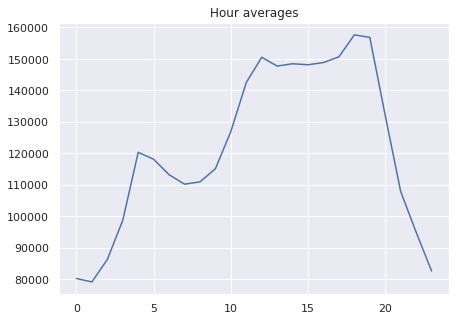

In [23]:
average_hour = code_mean(data, 'hour', "y")
plt.figure(figsize=(7, 5))
plt.title("Hour averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

А теперь, объединим все преобразования под одной функцией и добавим к признакам кодирование средним

In [24]:
def prepareData(series, lag_start, lag_end, test_size, target_encoding=False, get_dummies=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
            
        get_dummies: boolean
            if True - encode categorical into dummies
        
    """
    
    # copy of the initial dataset
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # lags of series
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # datetime features
    data.index = pd.to_datetime(data.index)
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # calculate averages on train set only
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # drop encoded variables 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
        
    if get_dummies:
        data = pd.get_dummies(data, columns=['hour', 'weekday'])
    
    # train-test split
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

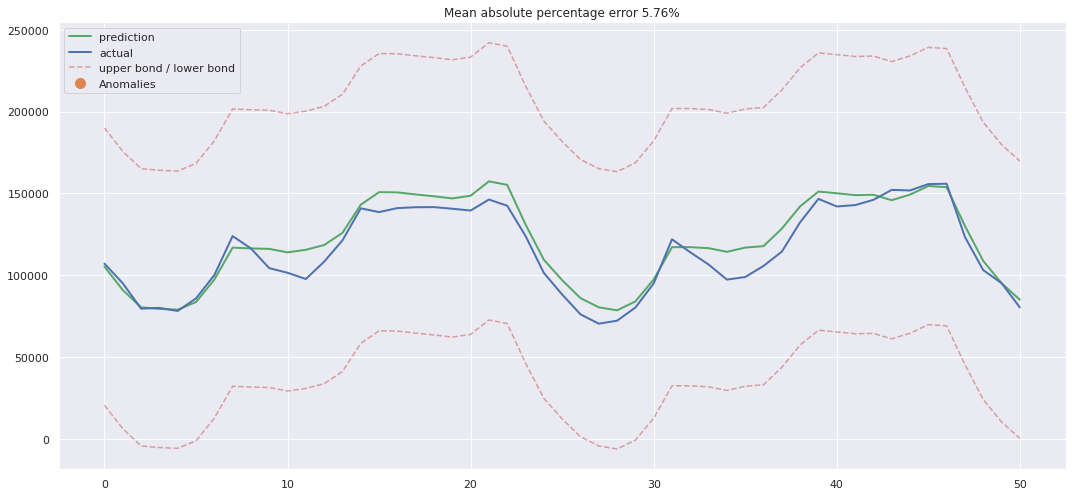

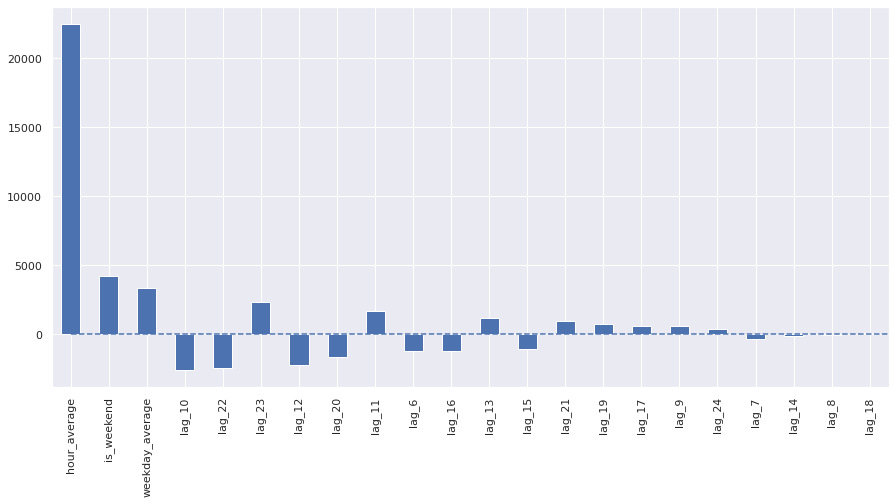

In [25]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

plotModelResults(lr, X_train=X_train_scaled, X_test=X_test_scaled, plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [26]:
len(X_train.loc[:, 'hour_average'].unique())

24

Кодирование средним - очень тонкий инструмент. С этой методикой нужно экспериментировать, но легко можно переобучиться, как это получилось на графиках выше. Точность упала, по сравнению с предыдущей моделью. Это произошло из-за того, что модель использовала практически только средние значения по часам. Средние значения по часам для каждого часа (сюрприз-сюрприз!) одинаковые.

Удобно, просто, но не эффективно, в данном случае.

А вот и немного переобучения, переменная hour_average настолько понравилась нашей модели на тренировочном датасете, что по ней, в основном, модель и стала прогнозировать. Решить эту проблему можно по-разному, например, считать средние таргета не по всему тренировочному датасету, а по некоторому последнему окну, которое будет лучше отражать последующее состояние ряда. Можно и просто руками выкинуть эту переменную, раз мы уверены, что она ведёт к ухудшению качества, что мы сейчас и сделаем.

Также дополнительно сделаем еще одно преобразование - сделаем из категориальных переменных дамми столбцы. Раз уж мы работаем с линейными моделями, имеет смысл разбить наши переменные "weekday" и "hour" на независимые столбцы, иначе получается нехорошая ситуация, когда 23-й час находится гораздо дальше от 1-го, чем от, например, 19-го. (Есть огромное количество и других методов работы с цикличными данными, такими как дни недели, часы в сутках или минуты в часах - например, можно кодировать их при помощи синусов и косинусов - https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/)

In [27]:
X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=False, get_dummies=True)

column_to_scale = [col for col in X_train.columns if 'lag' in col]
X_train_scaled = scaler.fit_transform(X_train[column_to_scale])
X_test_scaled = scaler.transform(X_test[column_to_scale])

X_train[column_to_scale] = X_train_scaled
X_test[column_to_scale] = X_test_scaled

Наплодили дамми-переменных. 

In [28]:
X_train.head()

,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
Time,,,,,,,,,,,,,,,,,,,,,
2017-09-14 00:00:00,1.462254,0.974267,0.751933,0.931678,0.889327,0.926818,1.160528,0.837541,0.166984,-0.392067,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 01:00:00,1.548454,1.447228,0.964154,0.741253,0.918151,0.875691,0.911138,1.151101,0.832507,0.161860,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 02:00:00,0.586940,1.533367,1.436354,0.952796,0.727666,0.904675,0.859628,0.899558,1.149545,0.830436,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 03:00:00,-0.623276,0.572521,1.522356,1.423488,0.939276,0.713126,0.888829,0.847603,0.895211,1.148930,...,0,0,0,0,0,0,1,0,0,0
2017-09-14 04:00:00,-0.951339,-0.636854,0.563053,1.509215,1.410117,0.925918,0.695847,0.877057,0.842680,0.893429,...,0,0,0,0,0,0,1,0,0,0


## Регуляризация и отбор признаков

Как мы уже выяснили, не все признаки одинаково полезны, а некоторые даже вредны и от них нужно срочно избавляться. Помимо выкидывания руками некоторых признаков, можно заняться регуляризацией. Сейчас мы рассмотрим две наиболее распространенных модели с регуляризацией - ридж и лассо регрессии. Они добавляют к нашей функции потерь, при помощи которой мы оптимизируем значения коэффициентов модели, еще немножко ограничений. 

В случае с ридж регрессией - это сумма квадратов коэффициентов модели, помноженная на коэффициент регуляризации. Т.е. чем больше значение коэффициента у переменной, тем больше будет наша ошибка, а значит, мы будем стараться оптимизировать одновременно как подгонку модели под данные, так и не давать коэффициентам сильно разрастаться. 

В результате такой регуляризации, которая носит гордое название $L2$, мы получаем бОльшее смещение, но меньший разброс, т.е. модель будет (по крайней мере мы на это очень надеемся) обладать лучшей обобщающей способностью. 

Вторая модель - лассо регрессия, в ней к функционалу ошибки добавляются не квадраты, а модули коэффициентов, в результате чего во время оптимизации коэффициенты перед факторами, которые оказываются не так важны, просто зануляются. Такой тип регуляризации называется $L1$. Таким образом, лассо регрессия автоматически позволяет производить отбор факторов для модели, сокращая признаковое пространство.

Для начала убедимся, что нам есть, что отбрасывать и в данных действительно очень много скоррелированных признаков

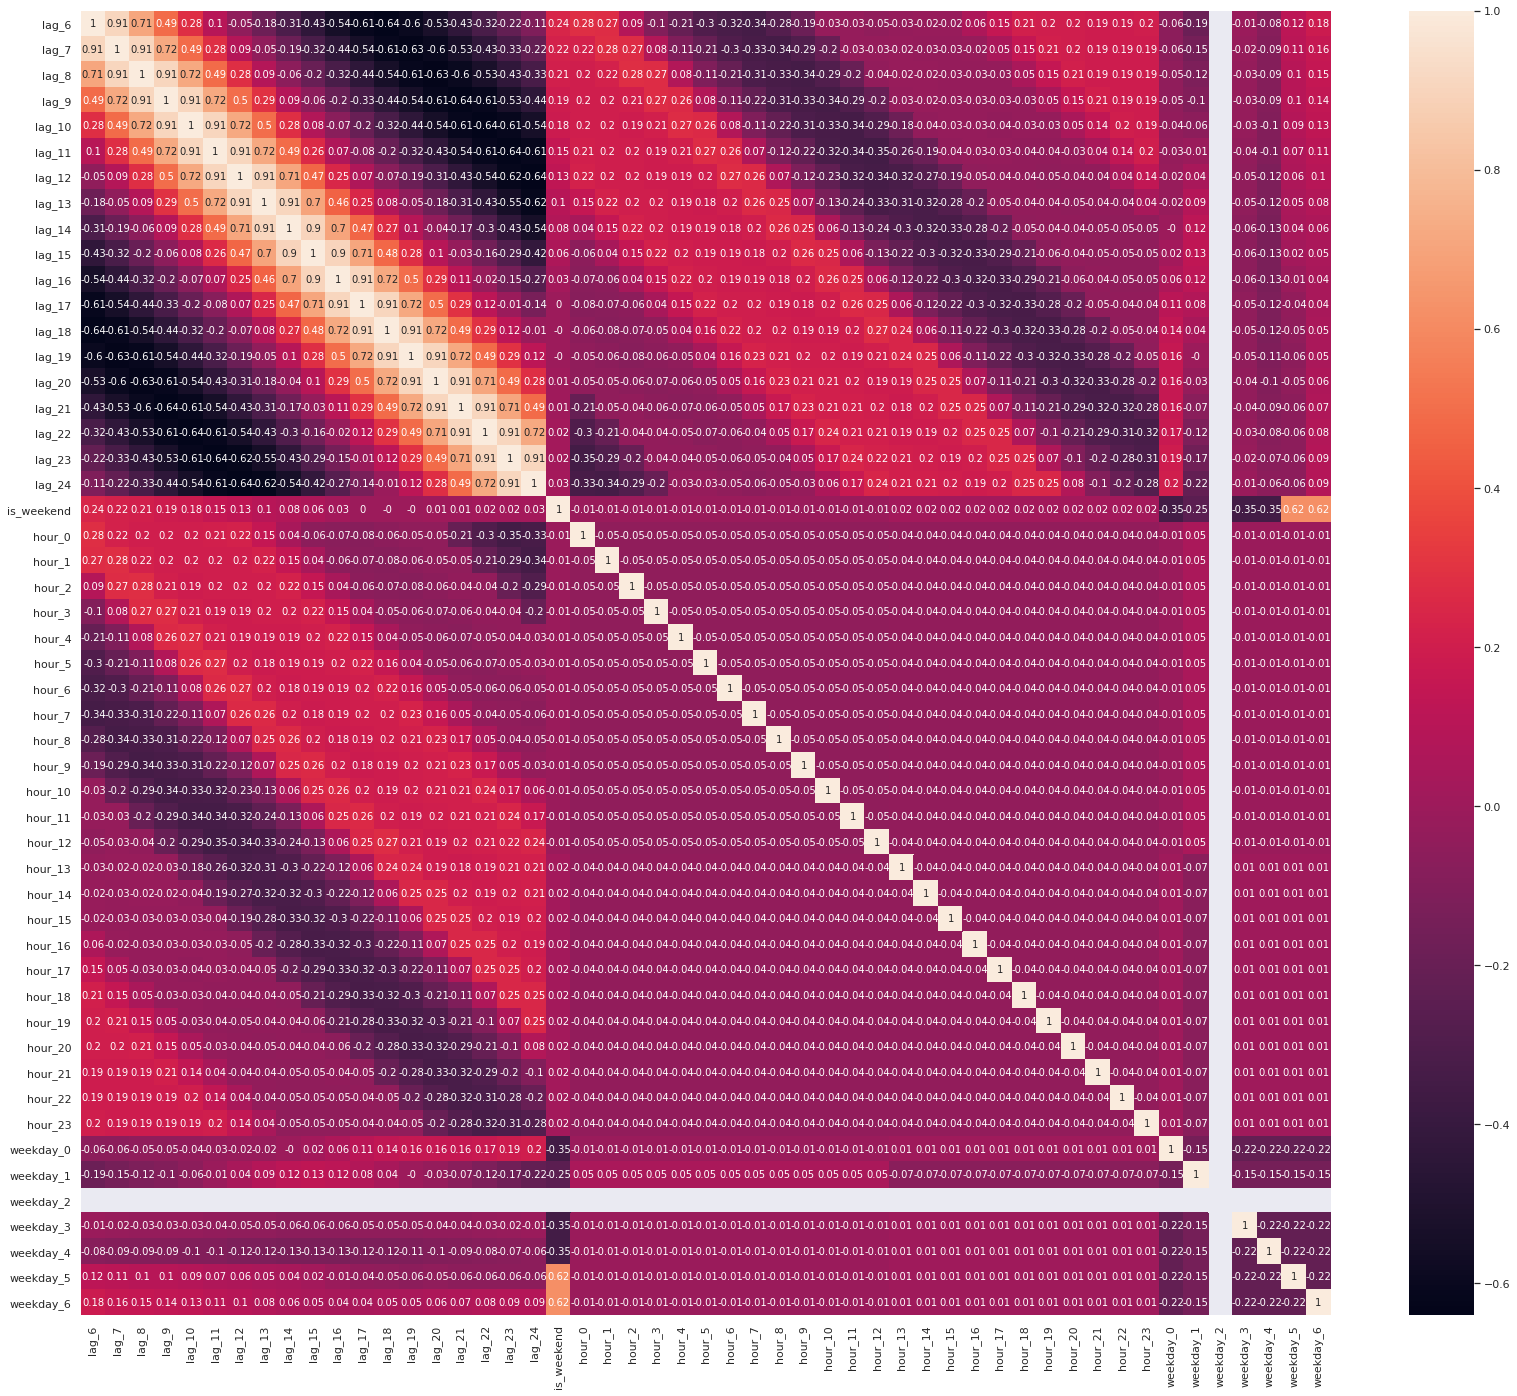

In [29]:
plt.figure(figsize=(28, 24))
sns.heatmap(round(X_train.corr(), 2), annot=True);

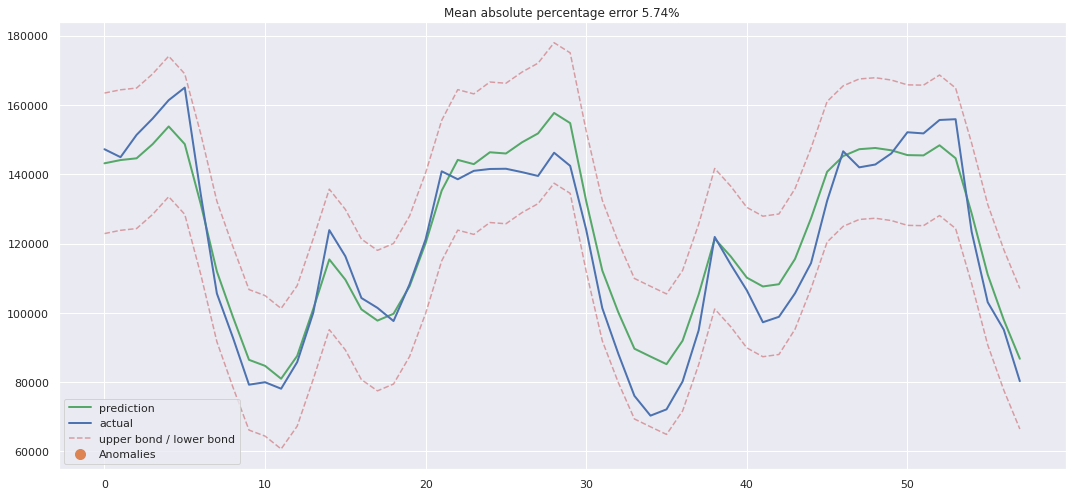

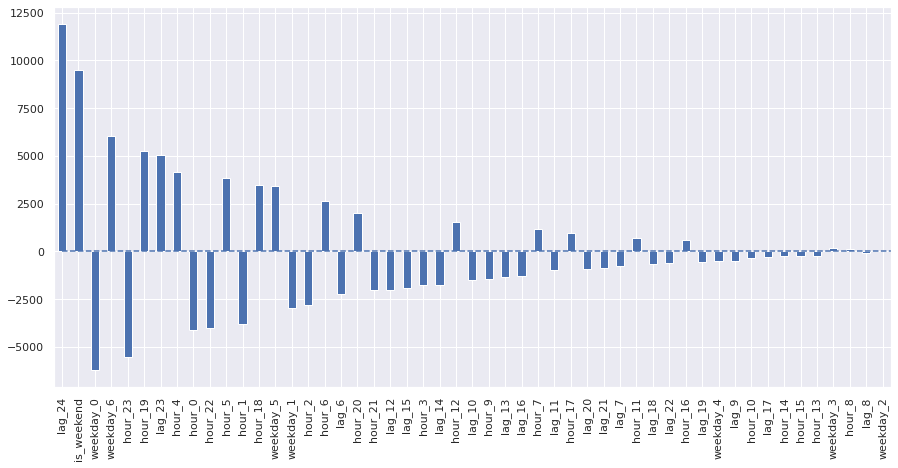

In [30]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv, alphas=np.linspace(5, 10))
ridge.fit(X_train, y_train)

plotModelResults(ridge, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

Хорошо видно, как всё ближе и ближе прижимаются к нулю (хотя никогда нулю не равны) коэффициенты в модели по мере убывания их важности. 

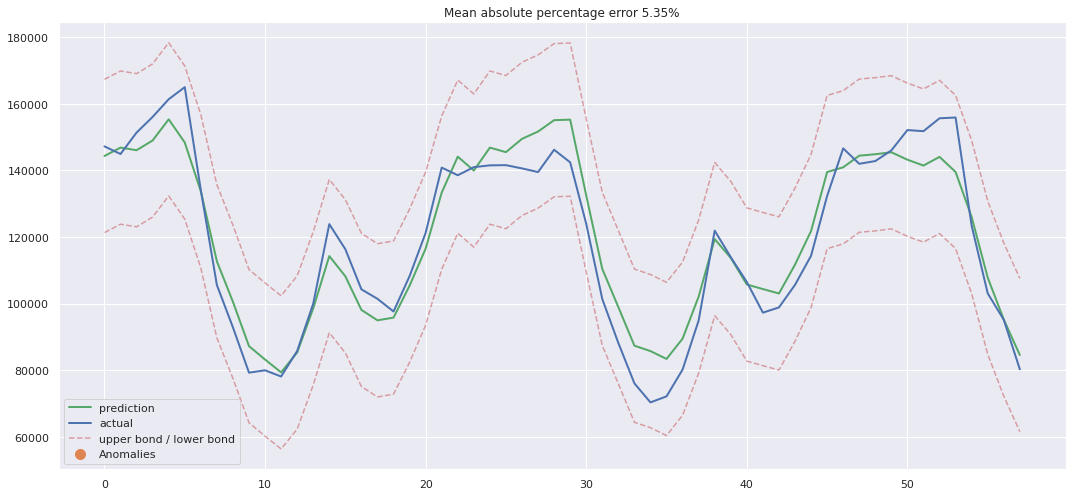

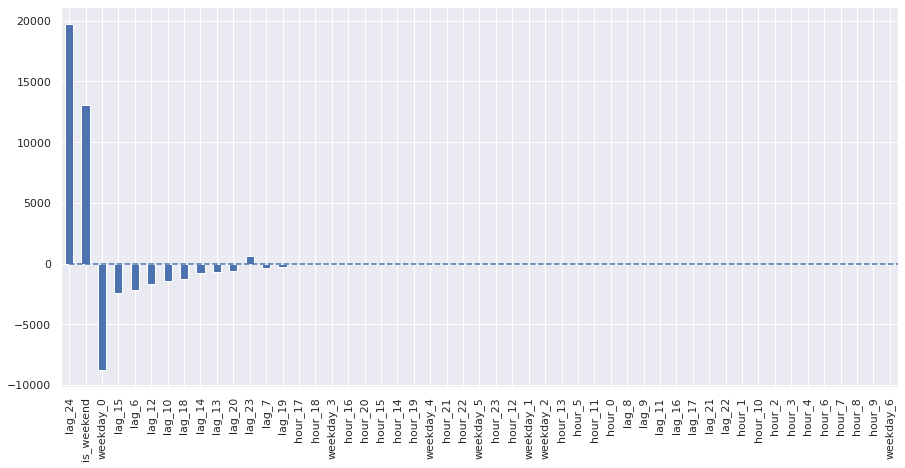

In [31]:
lasso = LassoCV(cv=tscv, eps=0.01)
lasso.fit(X_train, y_train)

plotModelResults(lasso, 
                 X_train=X_train, 
                 X_test=X_test, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Лассо регрессия оказалась более консервативой и убрала 23-й лаг из важных факторов модели, что, в результате, только пошло на пользу качеству на отложенной выборке.

Получив основные признаки с помощью lasso регрессии построим обычную тестовую регрессию с их помощью.

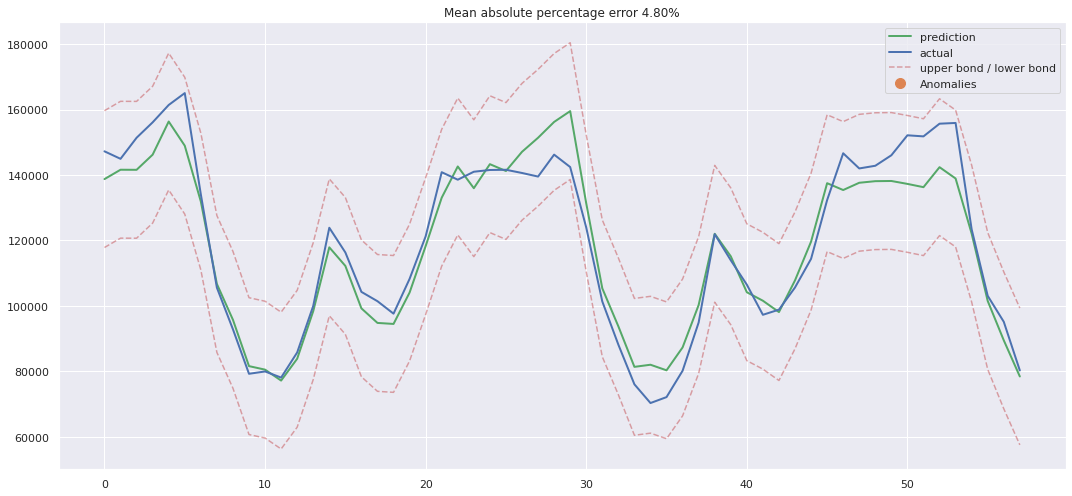

In [32]:
lr.fit(X_train[['lag_24', 'is_weekend', 'weekday_0']], y_train)

plotModelResults(lr, 
                 X_train=X_train[['lag_24', 'is_weekend', 'weekday_0']], 
                 X_test=X_test[['lag_24', 'is_weekend', 'weekday_0']], 
                 plot_intervals=True, plot_anomalies=True)

Хорошо получилось!

Как обычно: для линейных моделей стоит убирать "мусорные" признаки. Если признаки сильно скоррелированы - это плохо, от подобных признаков следует избавляться.

## Boosting

Почему бы теперь не попробовать бустинг?
<img src="https://habrastorage.org/files/754/a9a/26e/754a9a26e59648de9fe2487241a27c43.jpg"/>

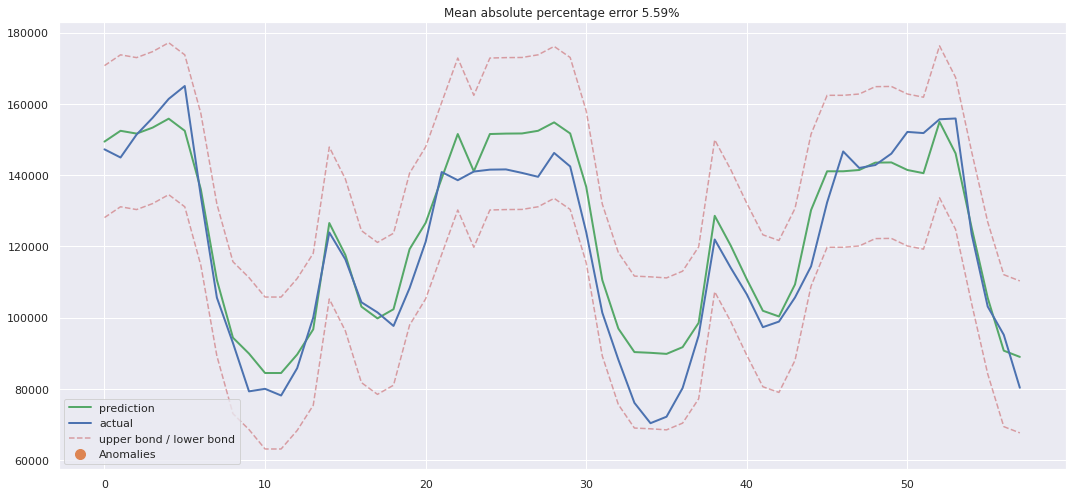

In [33]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor

gbr = AdaBoostRegressor(n_estimators=100)
gbr.fit(X_train_scaled, y_train)

plotModelResults(gbr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

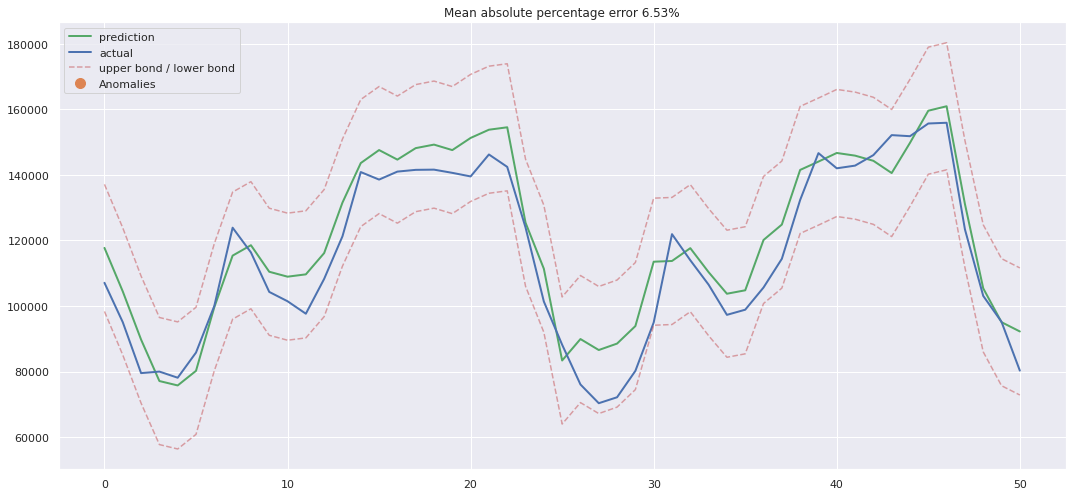

In [34]:
from catboost import CatBoostRegressor

X_train, X_test, y_train, y_test =\
prepareData(ads.Ads, lag_start=6, lag_end=25, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


catboost = CatBoostRegressor(iterations=100, learning_rate=0.7,
                          loss_function='RMSE', verbose=0)

catboost.fit(X_train_scaled, y_train, verbose=0)

plotModelResults(catboost, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

Не стоит первым делом при работе с временным рядом расчехлять xgboost. Дело в том, что модели с деревьями внутри, в отличие от линейных, довольно плохо справляются с трендами без помощи трюков с обработкой данных. В идеале - предварительно очистить данные от тренда, спрогнозировать тренд отдельно при помощи линейной модели, и отдельно - очищенный ряд, а потом сложить вместе предсказания.

Хорошая идея - использовать бустинговые модели на данных, очищенных от трендов и обучать регрессионную модель на данных с трендами. Результаты работы моделей складывать. 

# 5) To Infinity and Beyond

## Facebook Prophet - automating routines

![](https://miro.medium.com/max/1060/0*tVCene42rgUTNv9Q.png)

https://github.com/facebook/prophet

[Предсказываем будущее с помощью библиотеки Facebook Prophet](https://habrahabr.ru/company/ods/blog/323730/)

Библиотека prophet позволяет быстро и достаточно качественно автоматически строить прогнозы временных рядов. Подробно про теорию работы можно почитать в замечательной статьей по ссылке выше, а сейчас посмотрим на практике, как она работает

In [40]:
from fbprophet import Prophet

In [41]:
# number of future predictions
predictions = 60

# creating a specific format dataset 
df = ads.reset_index()
df.columns = ['ds', 'y']
df.tail()

,ds,y
211,2017-09-21 19:00:00,155890
212,2017-09-21 20:00:00,123395
213,2017-09-21 21:00:00,103080
214,2017-09-21 22:00:00,95155
215,2017-09-21 23:00:00,80285


In [42]:
# reserve some data for testing
train_df = df[:-predictions]

In [43]:
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(weekly_seasonality=True, yearly_seasonality=False)
model.fit(train_df)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=predictions, freq='H')
future.tail()

,ds
211,2017-09-21 19:00:00
212,2017-09-21 20:00:00
213,2017-09-21 21:00:00
214,2017-09-21 22:00:00
215,2017-09-21 23:00:00


In [44]:
# finally, making predictions
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
211,2017-09-21 19:00:00,127056.415311,139971.761540,161578.633051,127056.170138,127056.647126,24043.270657,24043.270657,24043.270657,27772.016248,27772.016248,27772.016248,-3728.745591,-3728.745591,-3728.745591,0.0,0.0,0.0,151099.685968
212,2017-09-21 20:00:00,127083.908611,123632.560625,145419.587038,127083.656561,127084.146353,7747.490390,7747.490390,7747.490390,11519.614726,11519.614726,11519.614726,-3772.124337,-3772.124337,-3772.124337,0.0,0.0,0.0,134831.399001
213,2017-09-21 21:00:00,127111.401912,102933.117121,124317.485534,127111.143160,127111.648087,-12949.823156,-12949.823156,-12949.823156,-9161.070585,-9161.070585,-9161.070585,-3788.752571,-3788.752571,-3788.752571,0.0,0.0,0.0,114161.578756
214,2017-09-21 22:00:00,127138.895212,84707.470294,105729.249359,127138.628000,127139.144916,-31608.761421,-31608.761421,-31608.761421,-27829.960488,-27829.960488,-27829.960488,-3778.800933,-3778.800933,-3778.800933,0.0,0.0,0.0,95530.133791
215,2017-09-21 23:00:00,127166.388512,72486.728547,94084.320013,127166.116091,127166.649225,-43864.393094,-43864.393094,-43864.393094,-40121.774144,-40121.774144,-40121.774144,-3742.618950,-3742.618950,-3742.618950,0.0,0.0,0.0,83301.995418


Mean absolute percentage error 8.64%


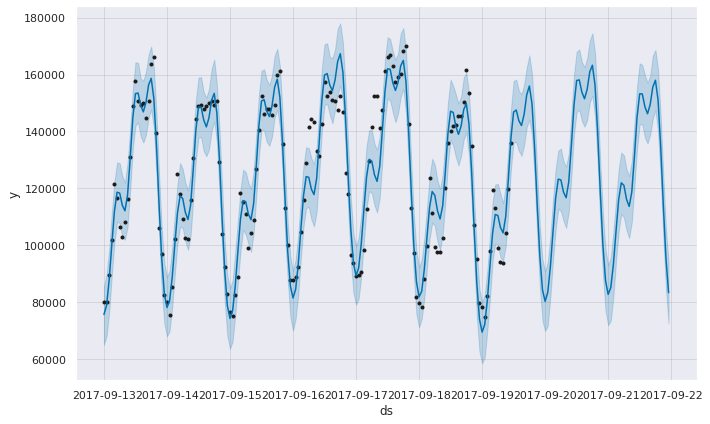

In [45]:
# pictures!
error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
print("Mean absolute percentage error {0:.2f}%".format(error * 100))
_ = model.plot(forecast)

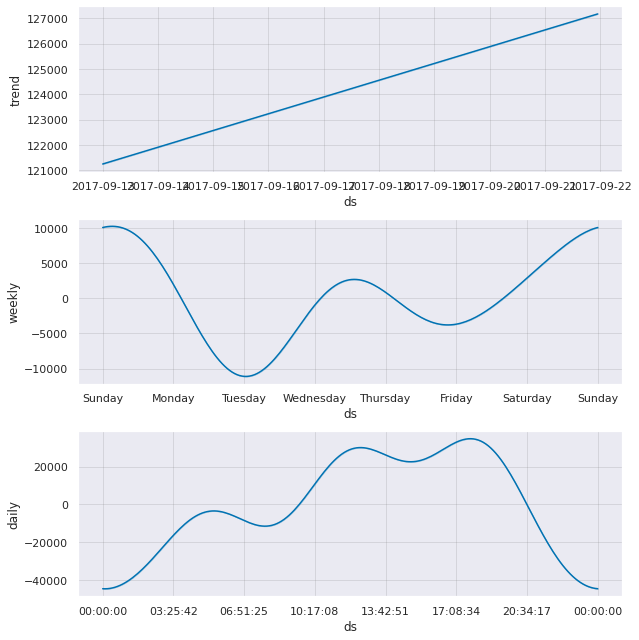

In [46]:
_ = model.plot_components(forecast)

#### *Заметка*: Данные, которые выдаёт фейсбучная модель можно использовать в качестве признаков для других моделей!

Как проапгрейдить библиотеки в файле dependencies.txt:

https://stackoverflow.com/questions/7225900/how-can-i-install-packages-using-pip-according-to-the-requirements-txt-file-from



# Amazon GluonTS - new big player on the market 

https://github.com/awslabs/gluon-ts

В июне 2019 года компания Amazon выложила в открытый доступ замечательный инструмент - [GluonTS](https://github.com/awslabs/gluon-ts), позволяющий максимально быстро и эффективно строить, оценивать и использовать модели временных рядов, основанные на глубоком обучении и вероятностном подходе. 

## Что внутри GluonTS?

Amazon пошёл дальше и использовал рекуррентные нейронные сети (в частности, LSTM), а также свертки и механизмы внимания, обернув всё это в крайне удобную верхнеуровневую библиотеку. В частности, GluonTS содержит:
- Инструменты, необходимые для построения и обучения наиболее распространённых архитектур нейронных сетей, а также компоненты для моделирования и трансформации вероятностых распределений
- Механизмы для загрузки и предварительной обработки данных, в том числе автоматической генерации признаков из временных рядов
- Несколько готовых к использованию state-of-the-art прогнозных моделей
- Инструменты для оценки и сравнения различных моделей

Если не вдаваться в подробности, GluonTS позволяет быстро и практически из коробки получить качественную модель временного ряда, на выходе из которой вместо точечной оценки прогнозных значений мы получаем целое смоделированное вероятностное распределение. Таким образом, мы можем с лёгкостью оперировать доверительными интервалами прогноза и с любой удобной нам вероятностью получать диапазон наиболее вероятных будущих значений ряда. 


В [оригинальной статье](https://aws.amazon.com/ru/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/) авторы использовали временной ряд с ценами акций компании Amazon. Ярко выраженных паттернов, за исключением восходящих/нисходящих трендов, в финансовых временных рядах обычно не бывает, поэтому прогнозы в статье выглядят больше как некоторый шум, колеблющийся вокруг спрогнозированной линии тренда.

Так что посмотрим, чего можно добиться на наших собственных данных

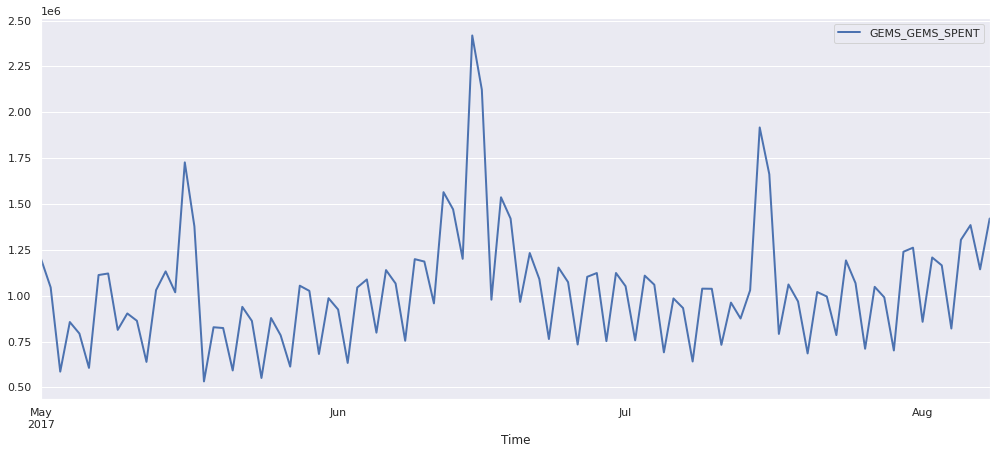

In [35]:
df = pd.read_csv(PATH + 'currency.csv', index_col=0)
df.index = pd.to_datetime(df.index)

df[:100].plot(linewidth=2, figsize=(17, 7))
plt.grid(axis='x')
plt.legend()
plt.show()

### Готовим данные

Попробуем построить модель. GluonTS предоставляет верхнеуровневую абстрацию `Dataset`, которая переводит разнородные форматы данных в один, удобный для последующей работы моделей. В частности, `ListDataset` переводит данные в список словарей, где отдельно записаны значения ряда и таймстэмпы. Для создания такого датасета мы передаём наш исходный временной ряд, указываем его частоту (в данном случае у нас дневные данные, поэтому частота ``"D"``), а также точку, до которой наш ряд будет отнесён к тренировочной выборке:

In [36]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [{"start": df.index[0], "target": df.GEMS_GEMS_SPENT[:"2017-08-01"]}],
    freq = "D"
)

Посмотрим, в какой формат преобразовались данные:

In [37]:
training_data.list_data

[{'start': Timestamp('2017-05-01 00:00:00'),
  'target': Time
  2017-05-01    1199436
  2017-05-02    1045515
  2017-05-03     586111
  2017-05-04     856601
  2017-05-05     793775
                 ...   
  2017-07-28     991163
  2017-07-29     701672
  2017-07-30    1239717
  2017-07-31    1261953
  2017-08-01     857930
  Name: GEMS_GEMS_SPENT, Length: 93, dtype: int64}]

## Обучаем модель

Имея такой датасет, можно переходить к построению модели. Внутри библиотеки есть огромное количество всевозможных гиперпараметров, начиная от самой архитектуры модели, и заканчивая настройкой первичной подготовки признаков для моделирования. 

В этой статье подробно разбирать настройку мы не будем, а вместо этого посмотрим, что может получиться, если воспользоваться решением из коробки. 

В качестве модели возьмем рекомендованную архитектуру, основанную на глубокой авторегрессионной модели ([DeepAR](https://arxiv.org/abs/1704.04110)). Как и при создании датасета, нужно не забыть указать частоту даных, на которой предстоит тренироваться. Также зададим число эпох равное 20, а горизонт прогноза (т.е. на сколько шагов вперед модель должна уметь прогнозировать) - равным 30 дням. 

In [38]:
from gluonts.model.deepar import DeepAREstimator
# from gluonts.trainer import Trainer
from gluonts.mx.trainer import Trainer

estimator = DeepAREstimator(
    freq="D", 
    prediction_length=30, 
    trainer=Trainer(epochs=20)
)
predictor = estimator.train(training_data=training_data)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:04<00:00, 10.55it/s, epoch=20/20, avg_epoch_loss=11.8]


После непродолжительной тренировки модель готова и можно смотреть на прогноз. Снова создадим `ListDataset`, на сей раз для отложенной выборки, и воспользуемся удобной утилитой `to_pandas`, чтобы перевести результаты прогноза в удобный для визуализации формат:

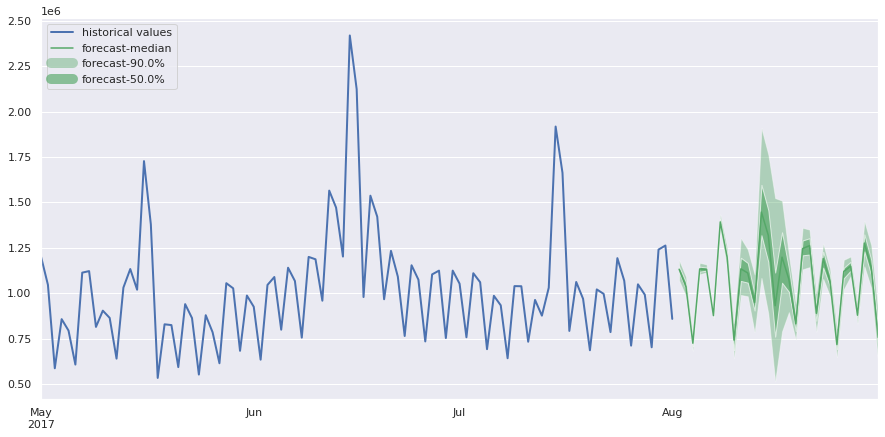

In [39]:
from gluonts.dataset.util import to_pandas

test_data = ListDataset(
    [{"start": df.index[0], "target": df.GEMS_GEMS_SPENT[:"2017-08-01"]}],
    freq = "D"
)

for test_entry, forecast in zip(test_data, predictor.predict(test_data)):
    to_pandas(test_entry).plot(linewidth=2, figsize=(15, 7), label="historical values")
    forecast.plot(color='g', prediction_intervals=[50.0, 90.0], label="forecast")
    
plt.legend(loc='upper left')
plt.grid(axis='x')

В результате мы получили очень правдоподобный прогноз, который учитывает и недельную сезонность и 30-дневную цикличность. Хорошо видно, что доверительные интервалы прогноза расширяются в момент пика, где исторические значения были наименее стабильными, и сужаются в обычные дни, где дисперсия исторических данных была не такой большой. 

GluonTS - очень удобный инструмент, который позволяет максимально быстро и верхнеуровнево получить вероятностую модель временного ряда, используя глубокое обучение под капотом. Помимо хороших результатов, которые получаются прямо из коробки, GluonTS можно тонко настраивать под любые нужды. 

# Time Series FeatuRe Extraction based on Scalable Hypothesis tests

## А вы и признаки за меня придумывать будете? 

<img src="https://tsfresh.readthedocs.io/en/latest/_images/introduction_ts_exa_features.png" width=500>


Основная идея библиотеки tsfresh - сгенерировать как можно больше признаков (если позволяют вычислительные ресурсы), а затем при помощи моделей или статистических критериев из этих признаков уже можно отобрать только те, которые релевантны для текущей задачи. Признаки могут быть как достаточно привычные - те же средние, максимальные и минимальные значения, так и довольно экзотичные, например, p-value коэффициента наклона линии тренда в текущем скользящем окне. Безусловно, не все эти признаки окажутся полезными (некоторые и вовсе могут оказаться константными), поэтому библиотека предоставляет небольшой инструментарий, который позволит быстро убрать самый откровенный мусор. 

Давайте разберём всё на интересном примере - распознавание активности человека по данным акселерометра с мобильного телефона: 

In [48]:
# импортируем необходимые функции из библиотеки
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

In [49]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

Загрузим данные, которые удобно находятся в самой библиотеке. Суммарно у нас есть 7352 наблюдений, каждому из которых сооветствуют 128 показаний акселерометра и одна из шести возможных активностей (подробное описание датасета можно найти [здесь](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones))

In [50]:
download_har_dataset()
data = load_har_dataset()
y = load_har_classes()
print(data.shape)
data.head()

(7352, 128)


,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,0.000181,0.010139,0.009276,0.005066,0.010810,0.004045,0.004757,0.006214,0.003307,0.007572,...,0.001412,-0.001509,0.000060,0.000435,-0.000819,0.000228,-0.000300,-0.001147,-0.000222,0.001576
1,0.001094,0.004550,0.002879,0.002247,0.003305,0.002416,0.001619,0.000981,0.000009,-0.000363,...,-0.000104,-0.000141,0.001333,0.001541,0.001077,-0.000736,-0.003767,-0.004646,-0.002941,-0.001599
2,0.003531,0.002285,-0.000420,-0.003738,-0.006706,-0.003148,0.000733,0.000668,0.002162,-0.000946,...,0.000661,0.001853,-0.000268,-0.000394,-0.000279,-0.000316,0.000144,0.001246,0.003117,0.002178
3,-0.001772,-0.001311,0.000388,0.000408,-0.000355,0.000998,0.001109,-0.003149,-0.008882,-0.010483,...,0.000458,0.002103,0.001358,0.000820,-0.000212,-0.001915,-0.001631,-0.000867,-0.001172,-0.000028
4,0.000087,-0.000272,0.001022,0.003126,0.002284,0.000885,0.001933,0.002270,0.002247,0.002175,...,0.002529,0.003518,-0.000248,-0.002761,0.000252,0.003752,0.001626,-0.000698,-0.001223,-0.003328


Для начала, давайте обучим простую модель на сырых данных, т.е. возьмем все 128 наблюдений акселерометра и засунем их в качестве признаков в случайный лес с дефолтными значениями. 

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=.2)

cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           1       0.69      0.69      0.69       235
           2       0.63      0.60      0.61       221
           3       0.71      0.74      0.72       178
           4       0.36      0.40      0.38       244
           5       0.44      0.42      0.43       299
           6       0.50      0.48      0.49       294

    accuracy                           0.54      1471
   macro avg       0.55      0.56      0.55      1471
weighted avg       0.54      0.54      0.54      1471



В результате получили бейзлайн оценки качества для нашей многоклассовой классификации. Хорошо видно, что некоторые классы модель распознает с большей точностью, чем другие (обычно на этом датасете сложнее всего отличить сидячих от стоячих людей).

Раз бейзлайн на сырых признаках есть - настало время извлечь что-то поинтереснее!

В tsfresh есть различные предустановленные варианты извлечения признаков, которыми можно воспользоваться из коробки и особо не думать насчет содержания. Отличаются они лишь количеством рассчитываемых признаков, а значит, скоростью обработки данных и количеством информации, которую эти признаки смогут передать. При желании, можно также вручную изменять набор рассчитываемых признаков. 

Первый и самый базовый набор признаков даёт `MinimalFCParameters`. Используя такую настройку мы получим джентельменский набор признаков для каждого наблюдения, а именно: сумму, медиану, среднее, длину, стандартное отклонение, дисперсию, максимальное и минимальное значения каждого ряда. 

Обычно такие признаки не дают хорошего качества (всё-таки их не так много и они представляют собой лишь базовые статистики, описывающие распределение значений). Однако такой набор удобно использовать для прототипирования, построения бейзлайнов или в случае, когда получение других признаков занимает слишком много времени.

In [52]:
settings_minimal = settings.MinimalFCParameters()
settings_minimal

{'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

Теперь посмотрим, как можно скомбинировать несколько разных вариантов извлечения признаков. Добавим к текущему минимальному набору еще один - `TimeBasedFCParameters`. Этот метод посчитает по нашему ряду линейный тренд, возьмет оттуда значение коэффициента R2, intercept, slope, стандартную ошибку и p-value и всё это сделает новыми признаками для объекта. При помощи простого совмещения двух словарей с правилами мы получаем уже чуть более интересный набор признаков, который по-прежнему будет достаточно быстро считаться даже на больших датасетах.

In [53]:
settings_time = settings.TimeBasedFCParameters()
settings_time.update(settings_minimal)
settings_time

{'linear_trend_timewise': [{'attr': 'pvalue'},
  {'attr': 'rvalue'},
  {'attr': 'intercept'},
  {'attr': 'slope'},
  {'attr': 'stderr'}],
 'sum_values': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variance': None,
 'maximum': None,
 'minimum': None}

Следующий набор - `EfficientFCParameters`. Здесь число различных признаков уже заметно выше, чем в предыдущих вариантах. Рассчитываются коэффициенты skewness и kurtosis, считается, сколько раз повторялось значение минимума и максимума, различные квантили, оконные статистики, автокорреляции и многое-многое другое. `Efficient` этот набор потому, что он по-прежнему относительно быстро считается и не требует значительных вычислительных затрат на построение признакового пространства.

In [54]:
settings_efficient = settings.EfficientFCParameters()
settings_efficient

{'variance_larger_than_standard_deviation': None,
 'has_duplicate_max': None,
 'has_duplicate_min': None,
 'has_duplicate': None,
 'sum_values': None,
 'abs_energy': None,
 'mean_abs_change': None,
 'mean_change': None,
 'mean_second_derivative_central': None,
 'median': None,
 'mean': None,
 'length': None,
 'standard_deviation': None,
 'variation_coefficient': None,
 'variance': None,
 'skewness': None,
 'kurtosis': None,
 'absolute_sum_of_changes': None,
 'longest_strike_below_mean': None,
 'longest_strike_above_mean': None,
 'count_above_mean': None,
 'count_below_mean': None,
 'last_location_of_maximum': None,
 'first_location_of_maximum': None,
 'last_location_of_minimum': None,
 'first_location_of_minimum': None,
 'percentage_of_reoccurring_values_to_all_values': None,
 'percentage_of_reoccurring_datapoints_to_all_datapoints': None,
 'sum_of_reoccurring_values': None,
 'sum_of_reoccurring_data_points': None,
 'ratio_value_number_to_time_series_length': None,
 'maximum': None,
 '

Наконец, самый большой и полный вариант - `ComprehensiveFCParameters`, в котором добавляются неэффективные в вычислительном плане признаки, но вполне возможно, что они дадут дополнительный прирост в качесве при обучении моделей.

In [55]:
settings_comprehensive = settings.ComprehensiveFCParameters()
len(settings_comprehensive)

71

Для текущего туториала, давайте возьмем эффективный список параметров и построим с его помощью наше новое признаковое пространство. 

Для начала нужно преобразовать датасет в `long` формат, необходимый для работы библиотеки. В этом формате у нас будет всего два столбца: в первом будут храниться все наблюдения акселерометров, во втором - соответствующий индекс наблюдения.

In [56]:
data_long = pd.DataFrame({0: data.values.flatten(),
                          1: np.arange(data.shape[0]).repeat(data.shape[1])})
print(data_long.shape)
data_long.head()

(941056, 2)


,0,1
0,0.000181,0
1,0.010139,0
2,0.009276,0
3,0.005066,0
4,0.010810,0


В результате наш датасет удлиннился практически до одного миллиона строк.  

Извлекаем признаки при помощи `extract_features`, указав в качестве параметров для извлечения наш эффективный список. Также укажем параметр для `impute_function`, передав туда функцию `impute`, импортированную выше из `tsfresh.utilities.dataframe_functions`. Эта функция автоматически заполнит все пропуски в получившемся датасете (если они там внезапно появятся)

In [57]:
X = extract_features(
    data_long, column_id=1, 
    impute_function=impute, 
    default_fc_parameters=settings_efficient,
    n_jobs=6
)
print(X.shape)

Feature Extraction: 100%|██████████| 30/30 [02:57<00:00,  5.92s/it]


(7352, 773)


Спустя пять минут работы библиотеки, получаем готовый датасет, где каждому наблюдению соответсвуют уже не 128 сырых значений акселерометра, а 788 извлеченных признаков.

Попробуем теперь обучить модель на них!

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
cl = DecisionTreeClassifier()
cl.fit(X_train, y_train)
print(classification_report(y_test, cl.predict(X_test)))

              precision    recall  f1-score   support

           1       0.90      0.95      0.93       244
           2       0.88      0.85      0.86       232
           3       0.92      0.89      0.91       198
           4       0.42      0.37      0.40       275
           5       0.47      0.48      0.48       273
           6       0.56      0.61      0.58       249

    accuracy                           0.68      1471
   macro avg       0.69      0.69      0.69      1471
weighted avg       0.67      0.68      0.67      1471



Ура, действительно, признаки оказались полезными и качество предсказаний заметно подросло по всем классам.

Но скорее всего, многие из извлеченных признаков на самом деле не нужны для построения предсказаний и могут быть спокойно выброшены. Для этого в библиотеке есть метод `select_features`, который рассчитывает важность текущего признака для предсказания класса. После рассчета ненужные признаки отбрасываются по p-value, при этом в функцию зашита поправка Бенджамини-Иекутиели на множественное тестирование.

In [59]:
relevant_features = set()

for label in y.unique():
    # select_features работает с бинарной классификацией, поэтому переводим задачу
    # в бинарную для каждого класса и повторяем по всем классам
    y_train_binary = y_train == label
    X_train_filtered = select_features(X_train, y_train_binary)
    relevant_features = relevant_features.union(set(X_train_filtered.columns))

len(relevant_features)

371

В результате получили заметно меньшей признаковое пространство, попробуем снова построить модель.

In [62]:
X_train_filtered = X_train[list(relevant_features)]
X_test_filtered = X_test[list(relevant_features)]

cl = DecisionTreeClassifier()
cl.fit(X_train_filtered, y_train)
print(classification_report(y_test, cl.predict(X_test_filtered)))

              precision    recall  f1-score   support

           1       0.92      0.93      0.92       244
           2       0.88      0.88      0.88       232
           3       0.92      0.91      0.92       198
           4       0.45      0.39      0.42       275
           5       0.48      0.50      0.49       273
           6       0.53      0.59      0.56       249

    accuracy                           0.68      1471
   macro avg       0.70      0.70      0.70      1471
weighted avg       0.68      0.68      0.68      1471



Отлично, отбросив мусорные признаки мы не только упростили модель, но еще и получили более высокое качество!